## Computer Science: COMS W 4995 006


## Due: October 13, 2022

#### Problem

You are given the noisy XOR data generated for you below. Your task is to implement a multi-layer perceptron binary classifier with one hidden layer. For the activiation function of the hidden units use ReLu. For the loss function use a softplus on a linear output layer as we did in class.

a) Implement each layer of the network as a separate function with both forward propagation and backpropagation. 

b) Train the network using stochastic gradient descent with mini-batches.  

c) Show the decision regions of the trained classifier by densely generating points in the plane and color coding these points with the binary labels. 

d) Repeat (b) and (c) varying the number of hidden units: 3, 16, 512. Discuss how the number of hidden units effects the solution.

e) Try choosing your own loss function (**without asking me or the TAs what you should choose**), repeating (d).

f) Now try with three inputs, generating your own training and testing data. (For this XOR the output should be a 1 if and only if exactly one of the inputs is 1. But make the training data noisy as before.) Use softplus loss. Do not try to show the decision regions, instead generate a test set in the same manner as the training set, classify the samples, and compute the classification accuracy.

g) Using your data from HW1 or any new data you curate if you don't think your HW1 data is appropriate for this assighnment, train your MLP using your training set (80%). Compute the error rate on your test set (20%). It's up to you how many hidden units to use. 

If you are struggling to get the network to converge, experiment with different learning rates.

Grading: a-d = 65%, e=10%, f=5%, g=20%. 

#### NOTE:  Do not to use keras, tensorflow, pytorch, sklearn, etc. to do this.  You must build the machine learning components from scratch.



Let's start by importing some libraries.

In [1]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

Let's make up some noisy XOR data.

In [2]:
data = pd.DataFrame(np.zeros((5000, 3)), columns=['x1', 'x2', 'y'])

# Let's make up some noisy XOR data to use to build our binary classifier
for i in range(len(data.index)):
    x1 = 1.0 * random.randint(0,1)
    x2 = 1.0 * random.randint(0,1)
    y = 1.0 * np.logical_xor(x1==1,x2==1)
    x1 = x1 + 0.15 * np.random.normal()
    x2 = x2 + 0.15 * np.random.normal()
    data.iloc[i,0] = x1
    data.iloc[i,1] = x2
    data.iloc[i,2] = y
        
data.head()

,x1,x2,y
0,0.890073,0.781251,0.0
1,0.804979,1.051563,0.0
2,1.441461,0.142178,1.0
3,0.921544,0.982318,0.0
4,0.888882,0.158317,1.0


Let's message this data into a numpy format.

In [3]:
# set X (training data) and y (target variable)
cols = data.shape[1]
X = data.iloc[:,0:cols-1]
y = data.iloc[:,cols-1:cols]

# The cost function is expecting numpy matrices so we need to convert X and y before we can use them.  
X = np.matrix(X.values)
y = np.matrix(y.values)

Let's make a sloppy plotting function for our binary data.

In [4]:
# Sloppy function for plotting our data
def plot_data(X, y_prob):
    
    fig, ax = plt.subplots(figsize=(12,8))
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

    y_predict = y_prob > 0.5
    indices_0 = [k for k in range(0, X.shape[0]) if not y_predict[k]]
    indices_1 = [k for k in range(0, X.shape[0]) if y_predict[k]]

    ax.plot(X[indices_0, 0], X[indices_0,1], marker='o', linestyle='', ms=5, label='0')
    ax.plot(X[indices_1, 0], X[indices_1,1], marker='o', linestyle='', ms=5, label='1')

    ax.legend()
    ax.legend(loc=2)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_title('Noisy XOR')
    plt.show()

Now let's plot it.

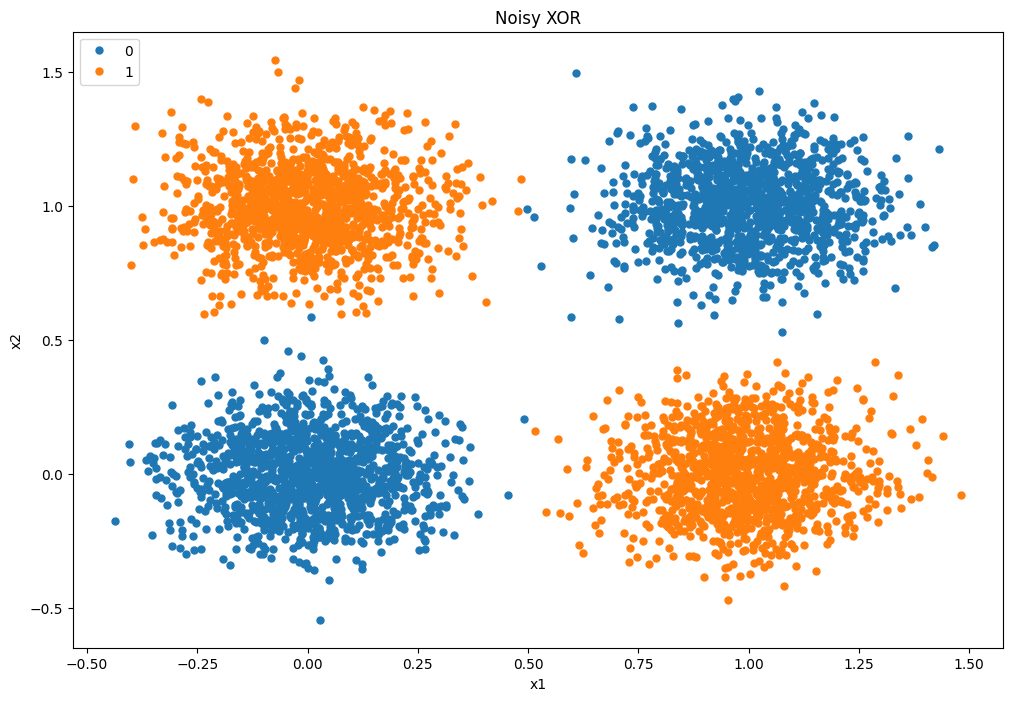

In [5]:
plot_data(X, y)

Now let's create functions for forward and backward prop through the layers and we are off...

In [6]:
controlY = y

In [7]:
# y = w^T * g(W^T*x + c) + b

# where x feeds into h and h feeds into y
# h is the hidden layer with nonlinear function g
# ReLU -> g(z) = max(0,z)
# therefore, y  = w^T * max(0,W^T*x + c) + b

# loss function: zeta(r) = log(1+e^r) (softplus)

# Put Y variables in big Y so we can reserve small y for propogation
Y = controlY
y = 0

class xor:
    def __init__(self,X,Y,units):
        self.X = X;
        self.Y = Y

        # Create randomized initial weights
        self.units = units
        self.W = np.random.rand(np.shape(X)[1],units)
        self.w = np.random.rand(units,1)
        self.c = np.random.rand(units,1)
        self.b = np.random.rand(1,1)
        self.h = np.zeros([np.shape(X)[0],1],dtype=float) # placeholders global variable for backtracking
        self.x = 0 # ^
        self.y = 0
        self.u1 = 0
        self.u2 = 0
        self.u3 = 0
        self.u4 = 0 # ^
        self.z = 0
        self.L = 0
        self.dLdu4 = 0
        self.dLdu3 = 0
        #self.dLdu2 = 0 # not used
        #self.dLdu1 = 0 # not used
        self.dLdz = 0
        self.dLdb = 0
        self.Lgradh = 0
        self.Lgradu2 = 0
        self.LgradW = 0
        self.Lgradw = 0
        self.Lgradc = 0
        self.du2dc = 0


    def ReLU(self,z):
        return np.maximum(z,0)

    def zeta(self,r):
        return np.log(1+np.exp(r))

    def sigmoid(self,r):
        return 1/(1+np.exp(-r))

    def f(self,z):
        return np.where(z < 0, 0, 1)

    ## Back: ################
    def backu4(self):
        self.dLdu4 = self.sigmoid(self.u4)
        self.backz()
        
    def backz(self):
        self.dLdz = self.dLdu4 * (1-2*self.y)
        self.backb()
        self.backu3()

    def backb(self):
        self.dLdb = self.dLdz
        

    def backu3(self):
        self.dLdu3 = self.dLdz.item()
        self.backw()
        self.backh()

    def backw(self):
        self.Lgradw = self.dLdu3 * self.h 
        

    def backh(self):
        self.Lgradh = self.dLdu3 * self.w
        self.backu2()

    def backu2(self):
        # Here, we have an interesting ReLU mapping to deal with 
        self.Lgradu2 = np.multiply(self.dLdu3 * self.f(self.u2),self.w)
        self.backc()
        self.backu1()

    def backc(self):
        self.du2dc = np.identity(self.units)
        self.Lgradc = np.matmul(self.du2dc.transpose(),self.Lgradu2)
        # should this be np.sum(np.multiply(f(self.u2),self.Lgradh)) ??? #f dot Lgradh #
        

    def backu1(self):
        self.Lgradu1 = self.Lgradu2
        self.backW()
        # no backtrack on sample x
    
    def backW(self):
        self.LgradW = (self.sigmoid(self.u4) * (1-2*self.y)).item() * self.x * np.multiply(self.f(self.u2),self.w).transpose()
        

    ## Forward: ################
    def forwardX(self):
        self.u1 = self.W.transpose()*self.x
        self.u2 = self.u1 + self.c
        self.h = self.ReLU(self.u2)
        self.forwardH()
        
    def forwardH(self):
        self.u3 = self.w.transpose()*self.h
        self.z = self.u3 + self.b
        self.forwardZ()
        
    def forwardZ(self):
        self.u4 = (1-2*self.y)*self.z
        self.forwardL()

    def forwardL(self):
        self.L = self.zeta(self.u4)
 
        
    def update(self):
        dS = 10**(-3) # learning rate
        
        self.W = self.W - self.LgradW*dS
        self.c = self.c - self.Lgradc*dS
        self.w = self.w - self.Lgradw*dS
        self.b = self.b - self.dLdb*dS
        # anything with Lgradh???
        # also self.L is never used anywhere (but we do use sigmoid output)
        # also, backc; is it correct?
        # not dot product, lement mult
        # f is 0-1 func, plug in the hidden layer after linear transformation
        # f i s looking at w transpose x + c 
        


    def train(self):
        # Iterate through every training sample x
        for i in range(np.shape(self.X)[0]):
            self.x = self.X[i].transpose()
            self.y = self.Y[i].item()

            self.forwardX()
            self.backu4()
            self.update()
            
def predict(xPred,obj):
    obj.x = xPred
    obj.y = 1
    obj.forwardX()
    return obj.sigmoid(obj.z) # OR SIGN OF Z
            



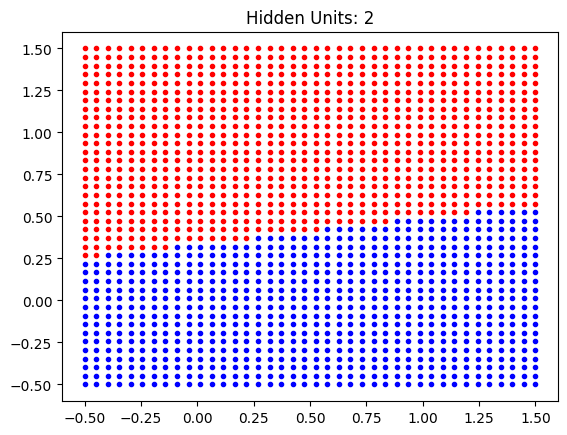

In [8]:
######## 2 HIDDEN UNITS ########
obj = xor(X,controlY,2)
obj.train()

plt.figure()
x1Plot = np.linspace(-.5,1.5,40)
x2Plot = np.linspace(-.5,1.5,40)
plt.title("Hidden Units: " + str(obj.units))

for x1 in x1Plot:
    for x2 in x2Plot:
        yPred = predict(np.matrix([x1,x2]).transpose(),obj)
        
        if(yPred >= 0.5): # yPred => 1
            plt.plot(x1,x2,"r.")
        else: # yPred => 0
            plt.plot(x1,x2,"b.")
        


        
plt.show()
        


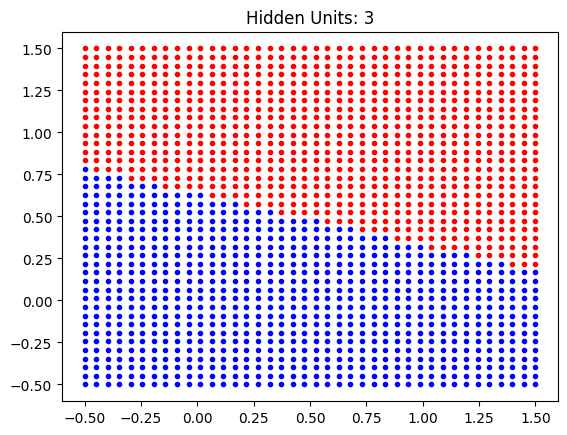

In [9]:
######## 3 HIDDEN UNITS ########
obj2 = xor(X,controlY,3)
obj2.train()

plt.figure()
x1Plot = np.linspace(-.5,1.5,40)
x2Plot = np.linspace(-.5,1.5,40)
plt.title("Hidden Units: " + str(obj2.units))

for x1 in x1Plot:
    for x2 in x2Plot:
        yPred = predict(np.matrix([x1,x2]).transpose(),obj2)
        
        if(yPred >= 0.5): # yPred => 1
            plt.plot(x1,x2,"r.")
        else: # yPred => 0
            plt.plot(x1,x2,"b.")
        


        
plt.show()

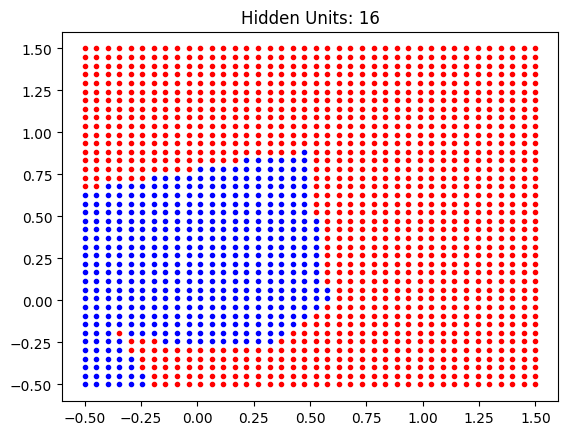

In [10]:
######## 16 HIDDEN UNITS ########
obj3 = xor(X,controlY,16)
obj3.train()

plt.figure()
x1Plot = np.linspace(-.5,1.5,40)
x2Plot = np.linspace(-.5,1.5,40)
plt.title("Hidden Units: " + str(obj3.units))

for x1 in x1Plot:
    for x2 in x2Plot:
        yPred = predict(np.matrix([x1,x2]).transpose(),obj3)
        
        if(yPred >= 0.5): # yPred => 1
            plt.plot(x1,x2,"r.")
        else: # yPred => 0
            plt.plot(x1,x2,"b.")
        


        
plt.show()

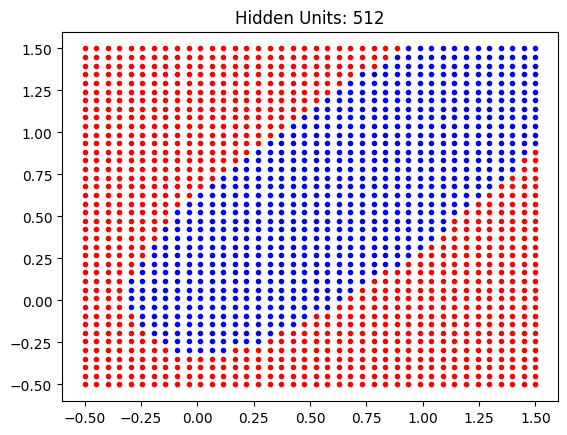

In [11]:
######## 512 HIDDEN UNITS ########
obj4 = xor(X,controlY,512)
obj4.train()

plt.figure()
x1Plot = np.linspace(-.5,1.5,40)
x2Plot = np.linspace(-.5,1.5,40)
plt.title("Hidden Units: " + str(obj4.units))

for x1 in x1Plot:
    for x2 in x2Plot:
        yPred = predict(np.matrix([x1,x2]).transpose(),obj4)
        
        if(yPred >= 0.5): # yPred => 1
            plt.plot(x1,x2,"r.")
        else: # yPred => 0
            plt.plot(x1,x2,"b.")
        


        
plt.show()

In [12]:
# Q: "Discuss how the number of hidden units effects the solution"
# A: There is a tradeoff between runtime and accuracy with respect to the number of hidden units.
#    As the number of hidden units increase, the computational price also increases as there are
#    more matrix calculations occurring within the forward and backward propogations. However,
#    this leads to significant accuracy improvements and leads to a better solution being found.

In [13]:
# Different Loss Function Class:
class xorDifferentLossFunc:
    def __init__(self,X,Y,units):
        self.X = X;
        self.Y = Y

        # Create randomized initial weights
        self.units = units
        self.W = np.random.rand(2,units)
        self.w = np.random.rand(units,1)
        self.c = np.random.rand(units,1)
        self.b = np.random.rand(1,1)
        self.h = np.zeros([2,1],dtype=float) # placeholders global variable for backtracking
        self.x = 0 # ^
        self.y = 0
        self.u1 = 0
        self.u2 = 0
        self.u3 = 0
        self.u4 = 0 # ^
        self.z = 0
        self.L = 0
        self.dLdu4 = 0
        self.dLdu3 = 0
        #self.dLdu2 = 0 # not used
        #self.dLdu1 = 0 # not used
        self.dLdz = 0
        self.dLdb = 0
        self.Lgradh = 0
        self.Lgradu2 = 0
        self.LgradW = 0
        self.Lgradw = 0
        self.Lgradc = 0
        self.du2dc = 0


    def ReLU(self,z):
        return np.maximum(z,0)

    def lossFunc(self,r): # LOSS FUNCTION (HINGE)
        return np.where(r < 1, 1-r,0)

    def lossDerivativeFunc(self,r): # LOSS DERIVATIVE (EITHER -1 or 0)
        return np.where(r < 1, -1,0)

    def f(self,z):
        return np.where(z < 0, 0, 1)

    ## Back: ################
    def backu4(self):
        self.dLdu4 = self.lossDerivativeFunc(self.u4)
        self.backz()
        
    def backz(self):
        self.dLdz = self.dLdu4 * (1-2*self.y)
        self.backb()
        self.backu3()

    def backb(self):
        self.dLdb = self.dLdz
        

    def backu3(self):
        self.dLdu3 = self.dLdz.item()
        self.backw()
        self.backh()

    def backw(self):
        self.Lgradw = self.dLdu3 * self.h 
        

    def backh(self):
        self.Lgradh = self.dLdu3 * self.w
        self.backu2()

    def backu2(self):
        # Here, we have an interesting ReLU mapping to deal with 
        self.Lgradu2 = np.multiply(self.dLdu3 * self.f(self.u2),self.w)
        self.backc()
        self.backu1()

    def backc(self):
        self.du2dc = np.identity(self.units)
        self.Lgradc = np.matmul(self.du2dc.transpose(),self.Lgradu2)
        # should this be np.sum(np.multiply(f(self.u2),self.Lgradh)) ??? #f dot Lgradh #
        

    def backu1(self):
        self.Lgradu1 = self.Lgradu2
        self.backW()
        # no backtrack on sample x
    
    def backW(self):
        self.LgradW = (self.lossDerivativeFunc(self.u4) * (1-2*self.y)).item() * self.x * np.multiply(self.f(self.u2),self.w).transpose()
        

    ## Forward: ################
    def forwardX(self):
        self.u1 = self.W.transpose()*self.x
        self.u2 = self.u1 + self.c
        self.h = self.ReLU(self.u2)
        self.forwardH()
        
    def forwardH(self):
        self.u3 = self.w.transpose()*self.h
        self.z = self.u3 + self.b
        self.forwardZ()
        
    def forwardZ(self):
        self.u4 = (1-2*self.y)*self.z
        self.forwardL()

    def forwardL(self):
        self.L = self.lossFunc(self.u4)
 
        
    def update(self):
        dS = 10**(-3) # learning rate
        
        self.W = self.W - self.LgradW*dS
        self.c = self.c - self.Lgradc*dS
        self.w = self.w - self.Lgradw*dS
        self.b = self.b - self.dLdb*dS
        # anything with Lgradh???
        # also self.L is never used anywhere (but we do use lossDerivativeFunc output)
        # also, backc; is it correct?
        # not dot product, lement mult
        # f is 0-1 func, plug in the hidden layer after linear transformation
        # f i s looking at w transpose x + c 
        


    def train(self):
        # Iterate through every training sample x
        for i in range(np.shape(self.X)[0]):
            self.x = self.X[i].transpose()
            self.y = self.Y[i].item()

            self.forwardX()
            self.backu4()
            self.update()

def predict2(xPred,obj):
    obj.x = xPred
    obj.y = 1
    obj.forwardX()
    return obj.z > 0

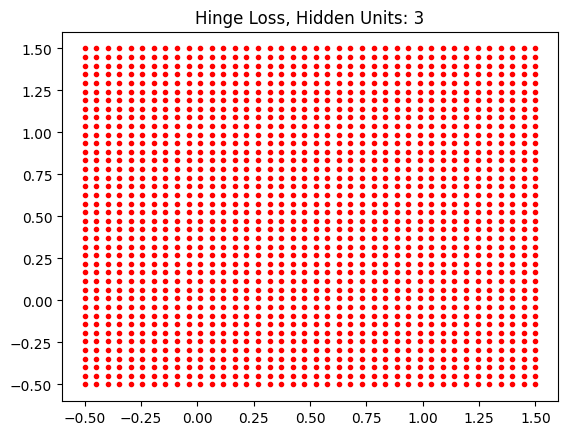

In [14]:
#################### HINGE LOSS FUNCTION: 3, 16, 512 HIDDEN UNITS #################

######## 3 HIDDEN UNITS ########
obj5 = xorDifferentLossFunc(X,controlY,3)
obj5.train()

plt.figure()
x1Plot = np.linspace(-.5,1.5,40)
x2Plot = np.linspace(-.5,1.5,40)
plt.title("Hinge Loss, Hidden Units: " + str(obj5.units))

for x1 in x1Plot:
    for x2 in x2Plot:
        yPred = predict2(np.matrix([x1,x2]).transpose(),obj5)
        
        if(yPred >= 0.5): # yPred => 1
            plt.plot(x1,x2,"r.")
        else: # yPred => 0
            plt.plot(x1,x2,"b.")
        


        
plt.show()

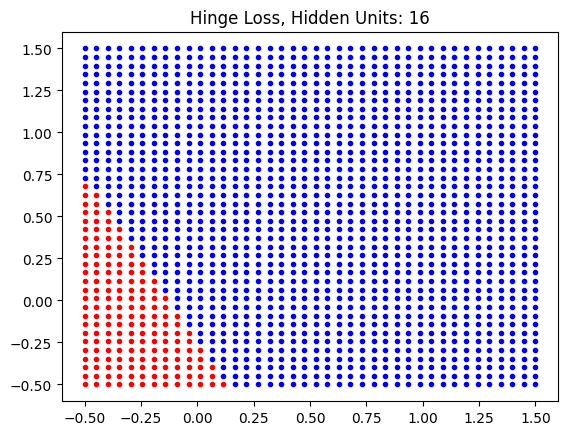

In [15]:
######## 16 HIDDEN UNITS ########
obj6 = xorDifferentLossFunc(X,controlY,16)
obj6.train()

plt.figure()
x1Plot = np.linspace(-.5,1.5,40)
x2Plot = np.linspace(-.5,1.5,40)
plt.title("Hinge Loss, Hidden Units: " + str(obj6.units))

for x1 in x1Plot:
    for x2 in x2Plot:
        yPred = predict2(np.matrix([x1,x2]).transpose(),obj6)
        
        if(yPred >= 0.5): # yPred => 1
            plt.plot(x1,x2,"r.")
        else: # yPred => 0
            plt.plot(x1,x2,"b.")
        


        
plt.show()

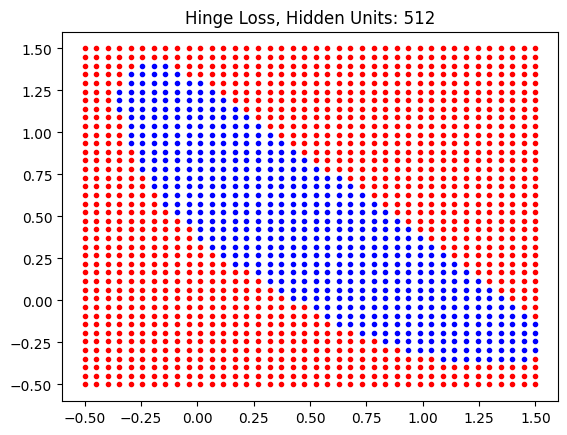

In [16]:
######## 512 HIDDEN UNITS ########
obj7 = xorDifferentLossFunc(X,controlY,512)
obj7.train()

plt.figure()
x1Plot = np.linspace(-.5,1.5,40)
x2Plot = np.linspace(-.5,1.5,40)
plt.title("Hinge Loss, Hidden Units: " + str(obj7.units))

for x1 in x1Plot:
    for x2 in x2Plot:
        yPred = predict2(np.matrix([x1,x2]).transpose(),obj7)
        
        if(yPred >= 0.5): # yPred => 1
            plt.plot(x1,x2,"r.")
        else: # yPred => 0
            plt.plot(x1,x2,"b.")
        


        
plt.show()

In [17]:
# Hinge Loss acts with a similar tradeoff but results in a different (and still valid) solution
# as the number of units nears infinity!!

In [36]:
########### Creating 3-dimensional training data for XOR ###############

data = pd.DataFrame(np.zeros((5000, 4)), columns=['x1', 'x2', 'x3', 'y'])

# Let's make up some noisy XOR data to use to build our binary classifier
for i in range(len(data.index)):
    x1 = 1.0 * random.randint(0,1)
    x2 = 1.0 * random.randint(0,1)
    x3 = 1.0 * random.randint(0,1)
    y = 1.0 * (x1+x2+x3 == 1)
    x1 = x1 + 0.15 * np.random.normal()
    x2 = x2 + 0.15 * np.random.normal()
    x3 = x3 + 0.15 * np.random.normal()
    data.iloc[i,0] = x1
    data.iloc[i,1] = x2
    data.iloc[i,2] = x3
    data.iloc[i,3] = y
        
data.head()

# set X (training data) and y (target variable)
cols = data.shape[1]
X = data.iloc[:,0:cols-1]
y = data.iloc[:,cols-1:cols]

# The cost function is expecting numpy matrices so we need to convert X and y before we can use them.  
X = np.matrix(X.values)
y = np.matrix(y.values)

In [37]:
######## 3 DIMENSIONAL, 512 HIDDEN UNITS - TRAINING DATA ########
obj8 = xor(X,y,512)
obj8.train()

In [38]:
########### Creating & Predicting 3-dimensional testing data for XOR ###############

data = pd.DataFrame(np.zeros((5000, 4)), columns=['x1', 'x2', 'x3', 'y'])

# Let's make up some noisy XOR data to use to build our binary classifier
for i in range(len(data.index)):
    x1 = 1.0 * random.randint(0,1)
    x2 = 1.0 * random.randint(0,1)
    x3 = 1.0 * random.randint(0,1)
    y = 1.0 * (x1+x2+x3 == 1)
    x1 = x1 + 0.15 * np.random.normal()
    x2 = x2 + 0.15 * np.random.normal()
    x3 = x3 + 0.15 * np.random.normal()
    data.iloc[i,0] = x1
    data.iloc[i,1] = x2
    data.iloc[i,2] = x3
    data.iloc[i,3] = y
        
data.head()

# set X (training data) and y (target variable)
cols = data.shape[1]
X = data.iloc[:,0:cols-1]
y = data.iloc[:,cols-1:cols]

# The cost function is expecting numpy matrices so we need to convert X and y before we can use them.  
X = np.matrix(X.values)
y = np.matrix(y.values)


numCorrect = 0
numWrong = 0
for i in range(np.shape(X)[0]):
    xTest = X[i].transpose()
    yTest = y[i].item()

    yPred = predict(xTest,obj8)
    
    if yPred > 0.5:
        yPred = 1
    else:
        yPred = 0
    
    if(yPred == yTest):
        numCorrect+=1
    else:
        numWrong+=1

print("Percentage Correct:",str(100*numCorrect/(numCorrect+numWrong)))

# Need much larger hidden unit count in order to keep up with the dimensionality!! Too much inaccuracy

Percentage Correct: 75.02


In [45]:
####### GET HW1 DATA ########
path = "/Users/blake/Documents/COMS 4995 - DL CV/HW1/" # note: the link to this dataset is at the bottom of this file
fn = "HW1 Post Processed Training Data.xlsx"

# Read post processed data data
df = pd.read_excel(path+fn)

data = pd.DataFrame(np.zeros((df.shape[0],4)), columns=['x1', 'x2', 'x3', 'y'])

# Let's make up some noisy XOR data to use to build our binary classifier
for i in range(df.shape[0]):
    x1 = df.at[i,"Radius"]
    x2 = df.at[i,"Symmetry"]
    x3 = df.at[i,"Smoothness"]
    if df.at[i,'Diagnosis'] == 'B':
        y = 0
    else:
        y = 1
    data.iloc[i,0] = x1
    data.iloc[i,1] = x2
    data.iloc[i,2] = x3
    data.iloc[i,3] = y

data.head()

# set X (training data) and y (target variable)
cols = data.shape[1]
X = data.iloc[:,0:cols-1]
y = data.iloc[:,cols-1:cols]

# The cost function is expecting numpy matrices so we need to convert X and y before we can use them.  
X = np.matrix(X.values)
y = np.matrix(y.values)


In [46]:
####### TRAIN WITH HW1 DATA ######
obj9 = xor(X,y,64)
obj9.train()

In [47]:
######## TEST OUT CLASSIFIER WITH HW1 DATA #######

## Experiment With Test Data
# Read test file
path = "/Users/blake/Documents/COMS 4995 - DL CV/HW1/"
fn2 = "HW1 Post Processed Test Data.xlsx"
df = pd.read_excel(path+fn2)

correctCount = 0
incorrectCount = 0

data = pd.DataFrame(np.zeros((df.shape[0],4)), columns=['x1', 'x2', 'x3', 'y'])
for i in range(df.shape[0]):
    x1 = df.at[i,"Radius"]
    x2 = df.at[i,"Symmetry"]
    x3 = df.at[i,"Smoothness"]
    if df.at[i,'Diagnosis'] == 'B':
        y = 0
    else:
        y = 1
    data.iloc[i,0] = x1
    data.iloc[i,1] = x2
    data.iloc[i,2] = x3
    data.iloc[i,3] = y

data.head()

# set X (training data) and y (target variable)
cols = data.shape[1]
X = data.iloc[:,0:cols-1]
y = data.iloc[:,cols-1:cols]

# The cost function is expecting numpy matrices so we need to convert X and y before we can use them.  
X = np.matrix(X.values)
y = np.matrix(y.values)

for i in range(np.shape(X)[0]):
    xTest = X[i].transpose()
    yTest = y[i].item()

    yPred = predict(xTest,obj9)
    
    if yPred > 0.5:
        yPred = 1
    else:
        yPred = 0
    
    if(yPred == yTest):
        correctCount+=1
    else:
        incorrectCount+=1
        

print("Percentage Correct:",str(100*correctCount/(correctCount+incorrectCount)))

Percentage Correct: 75.1592356687898


In [24]:
# HW1 Training & Test Data: https://drive.google.com/drive/folders/1TfdPJfSQ5h4U5-CQhbH8jkkeNhC2EZkG?usp=sharing